# Importing Kinematic modelling into GemPy using pynoddy

In [1]:
import sys, os
# Path to development gempy
sys.path.append('../../..')

# Path to development pynoddy
sys.path.append('../../../../pynoddy')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pn
# adjust some settings for matplotlib
from matplotlib import rcParams
# print rcParams
rcParams['font.size'] = 15
# determine path of repository to set paths corretly below
repo_path = os.path.realpath('../..')
import gempy as gp
import pynoddy
import pynoddy.history
import pynoddy.output
%matplotlib inline

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Making your favorite model in pynoddy
### Loading noddy model

In [2]:
#reload(pynoddy.history)
# Downloading a model
his = pynoddy.history.NoddyHistory(url = \
            "http://tectonique.net/asg/ch2/ch2_2/ch2_2_1/his/normal.his")

his.determine_model_stratigraphy()

In [3]:
# Choosing resolution
his.change_cube_size(500)

In [4]:
# Writing history file
history_name = "fold_thrust.his"
his.write_history(history_name)

In [5]:
# Computing history file
output = "fold_thrust_out"
pynoddy.compute_model(history_name, output, sim_type='TOPOLOGY')

''

In [6]:
# load and visualise model
h_out = pynoddy.output.NoddyOutput(output)

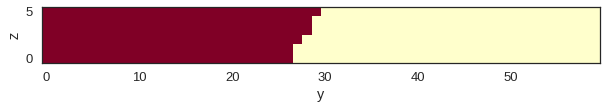

In [7]:
# his.determine_model_stratigraphy()
h_out.plot_section('x', 
                   layer_labels = his.model_stratigraphy, 
                   colorbar_orientation = 'horizontal', 
                   colorbar=False,
                   title = '',
#                   savefig=True, fig_filename = 'fold_thrust_NS_section.eps',
                   cmap = 'YlOrRd')

In [8]:
h_out.delz

500.0

In [9]:
# Checkpoint. Saving noddy litholody block
np.save('noddy_block', h_out.block)

## GemPy finding interface points

In [18]:
# Creating geo_data with the same data extent and resolution as the noddy model

# initialize geo_data object
geo_data = gp.create_data([-3000, 33000, 
                           -3000, 33000, 
                           0, 3000],
                          resolution=[50, 50, 50])
block = np.load('noddy_block.npy')

In [15]:
extent = [0, 30000.0,
          0, 30000.0,
          0, 3000.0  ]# h_out.extent_x, h_out.extent_y, h_out.extent_z

cs = 500 #h_out.delx

resolution = [int(extent[1]/cs), 
              int(extent[3]/cs), 
              int(extent[5]/cs)]

noddy_grid = gp.GridClass.create_regular_grid_3d(extent, resolution)

In [19]:
# Importing some points at the interface
gp.utils.set_interfaces_from_block(geo_data, block, noddy_grid, reset_index=True)

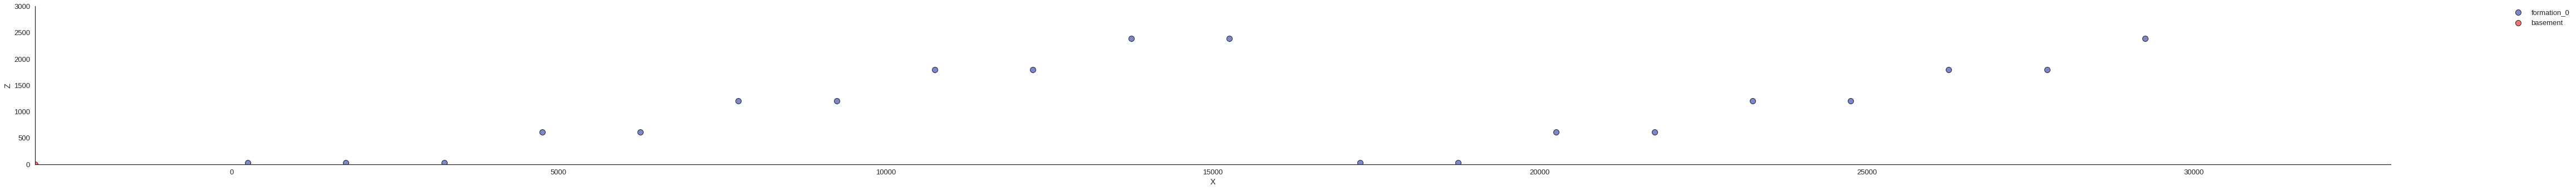

In [20]:
# Visualiziing
gp.plotting.plot_data(geo_data)

In [29]:
geo_data.interfaces.head()

,X,Y,Z,annotations,formation,formation_number,formation_value,isFault,order_series,series
0,26250.0,14250.0,1795.0,"${\bf{x}}_{\alpha \,{\bf{1}},0}$",formation_0,1,2.5,False,1,Default series
1,12250.0,14250.0,1795.0,"${\bf{x}}_{\alpha \,{\bf{1}},1}$",formation_0,1,2.5,False,1,Default series
2,250.0,13250.0,25.0,"${\bf{x}}_{\alpha \,{\bf{1}},2}$",formation_0,1,2.5,False,1,Default series
3,1750.0,13250.0,25.0,"${\bf{x}}_{\alpha \,{\bf{1}},3}$",formation_0,1,2.5,False,1,Default series
4,3250.0,13250.0,25.0,"${\bf{x}}_{\alpha \,{\bf{1}},4}$",formation_0,1,2.5,False,1,Default series


In [21]:
# Setting orientation from interfaces
gp.set_orientation_from_interfaces(geo_data, [5,6,7,8,9,10,11,12])

,X,Y,Z,G_x,G_y,G_z,dip,azimuth,polarity,formation,series,formation_number,order_series,isFault,annotations,formation_value
0,13875.0,13875.0,1500.0,0.000261,-0.853962,0.520335,58.645254,179.982509,1.0,formation_0,Default series,1,1,False,"${\bf{x}}_{\beta \,{\bf{1}},0}$",1


In [51]:
gp.plotting.plot_data_3D(geo_data)

closing vtk


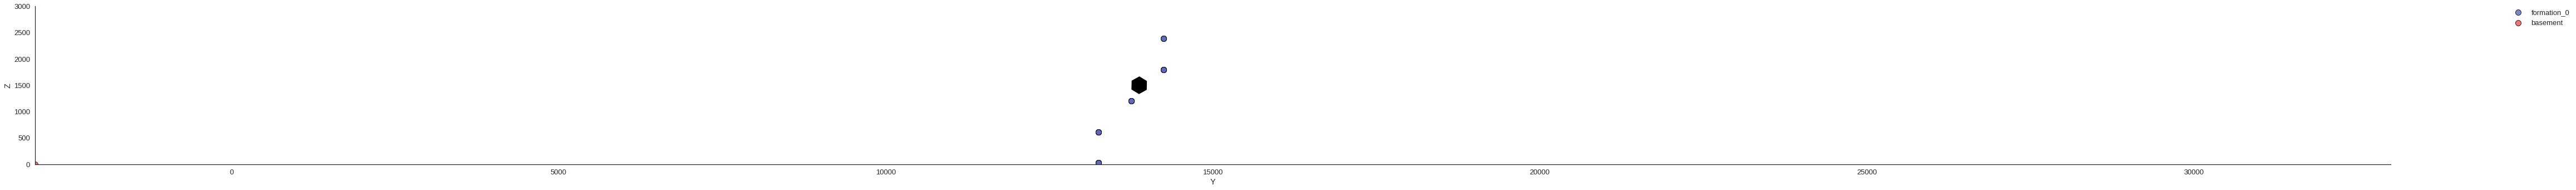

In [19]:
gp.plotting.plot_data(geo_data, direction='x')

### Computing and visualizing gempy model

In [20]:
interp_data = gp.InterpolatorData(geo_data, compile_theano=True)

Compiling theano function...
Compilation Done!
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float32
Number of faults:  0


In [21]:
lith, fault = gp.compute_model(interp_data)

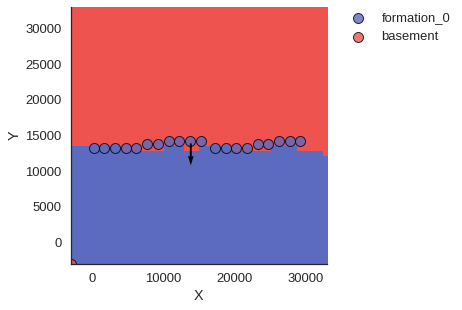

In [25]:
gp.plotting.plot_section(geo_data, lith[0], 3, direction='', plot_data= True)

In [27]:
ver, sim = gp.get_surfaces(interp_data, lith[1], None)
gp.plotting.plot_surfaces_3D_real_time(geo_data, interp_data, ver, sim)

closing vtk


## Comparing physics
### pynoddy gravity

Density is 2.5 and 3.5

In [11]:
pynoddy.compute_model(history_name, output, sim_type = 'GEOPHYSICS')

''

In [13]:
geophys = pynoddy.output.NoddyGeophysics(output)

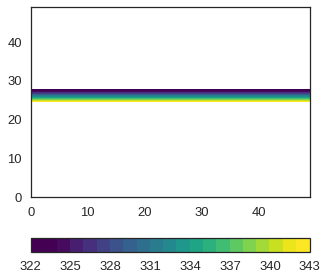

In [42]:
fig = plt.figure(figsize = (5,5))
ax = fig.add_subplot(111)
# imshow(geophys.grv_data, cmap = 'jet')
# define contour levels
levels = np.arange(322,344,1)
cf = ax.contourf(geophys.grv_data, levels, cmap = 'viridis', vmin = 324, vmax = 342)
cbar = plt.colorbar(cf, orientation = 'horizontal')

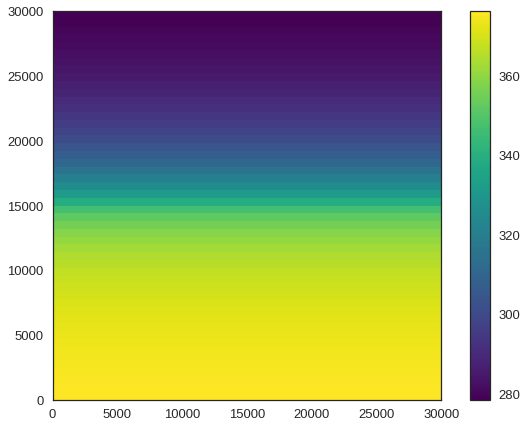

In [54]:
import matplotlib.pyplot as plt

plt.imshow(geophys.grv_data, cmap='viridis', origin='lower',
           extent=extent[:-2] )
plt.colorbar()

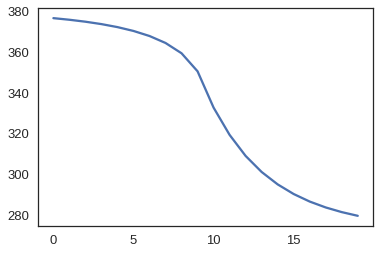

In [17]:
plt.plot(geophys.grv_data[:,0])

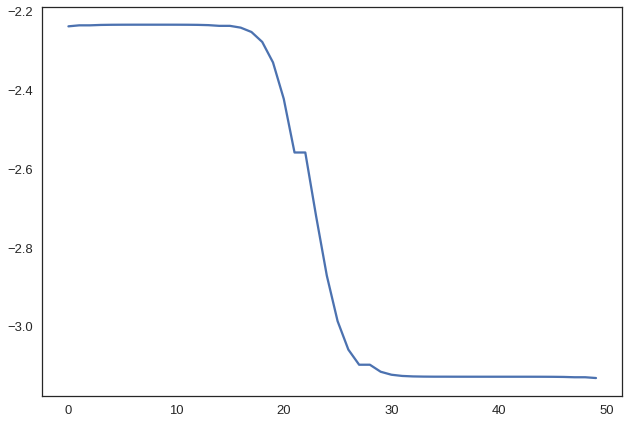

In [28]:
plt.plot(grav.reshape(50,50)[:,0])

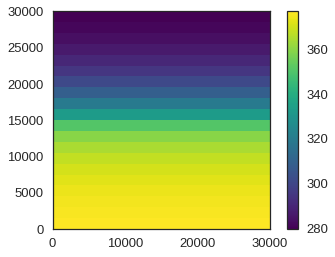

In [16]:
import matplotlib.pyplot as plt

plt.imshow(geophys.grv_data, cmap='viridis', origin='lower',
           extent=extent[:-2] )
plt.colorbar()

In [26]:
gp.get_data(geo_data, 'formations')

,value,formation_number
formation_0,1,1
basement,2,2


In [22]:
gp.set_formations(geo_data, formations_values=[2.5, 3.5])

,value,formation_number
formation_0,2.5,1
basement,3.5,2


In [23]:
interp_data_grav = gp.InterpolatorData(geo_data, output='gravity',
                                       compile_theano=True)

Compiling theano function...
Compilation Done!
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float32
Number of faults:  0


In [24]:
gp.set_geophysics_obj(interp_data_grav,
                      extent,
                      [50, 50])


In [25]:
gp.precomputations_gravity(interp_data_grav, 25);

In [45]:
interp_data_grav.update_interpolator(geo_data)

In [26]:
lith, fault, grav = gp.compute_model(interp_data_grav, 'gravity')

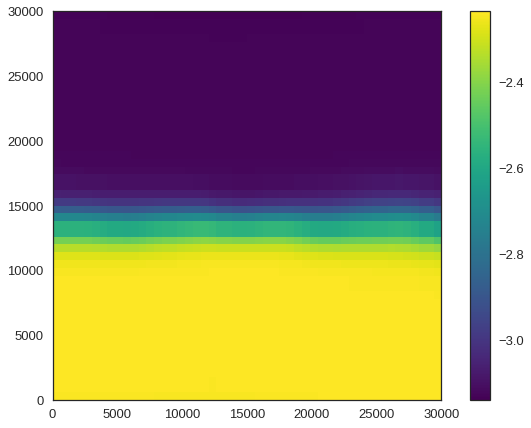

In [27]:
import matplotlib.pyplot as plt

plt.imshow(grav.reshape(50,50), cmap='viridis', origin='lower',
           extent=extent[:-2] )
plt.colorbar()